In [1]:
### Code to convert segment data to coordinate 
### characteristics:
### - consider only the bigger nodule as the real one!

In [2]:
import SimpleITK as sitk
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import numpy as np
import glob
import matplotlib
from utils import (
    load_itk, resample, 
    gen_coordinate_and_mask,
)
from skimage import measure
from matplotlib import pyplot as plt
from tqdm import tqdm
import pandas as pd

from sklearn.cluster import KMeans

### HC dataset

In [3]:
MASK_PATH = r'/data/HC1/*/103*'
mask_list = glob.glob(MASK_PATH)
print(len(mask_list))
print(mask_list[0])

101
/data/HC1/PL032303325116347/103 RTSTRUCT AutoSS-bone-label.nrrd


In [4]:
# mask_list = list(filter(lambda k: 'PL145353604730560' in k, mask_list))
mask_list = list(filter(lambda k: 'PL909112578062532' in k, mask_list))
# mask_list = list(filter(lambda k: 'PL652297908013408' in k, mask_list))
mask_list

['/data/HC1/PL909112578062532/103 RTSTRUCT AutoSS-bone-label.nrrd']

### MSD dataset

In [5]:
# MASK_PATH = r'/data/MSD/Task06_Lung/labelsTr/lung*'
# mask_list = glob.glob(MASK_PATH)
# print(len(mask_list))
# print(mask_list[0])

### unique exam

In [6]:
%%time
img, origin, spacing = load_itk(mask_list[0])

print(np.unique(img, return_counts=True))
print(img.shape)
print(origin, spacing)

(array([0, 1], dtype=int16), array([75742804,    16812]))
(289, 512, 512)
[-347.75 -202.5  -202.5 ] [1.25     0.791016 0.791016]
CPU times: user 837 ms, sys: 116 ms, total: 953 ms
Wall time: 1 s


In [7]:
%%time
img2, spacing2 = resample(img, spacing, [1.25, 0.703125, 0.703125])

print(np.unique(img2, return_counts=True))
print(img2.shape)
print(origin, spacing2)

(array([0, 1], dtype=int16), array([95861978,    21286]))
(289, 576, 576)
[-347.75 -202.5  -202.5 ] [1.25       0.70312532 0.70312532]
CPU times: user 48.7 s, sys: 154 ms, total: 48.8 s
Wall time: 48.8 s


In [8]:
%%time
x, y, z = img2.shape

count = 0
coordinates = []
for i in range(x):
    for j in range(y):
        for k in range(z):
             if img2[i][j][k] == 1:
                 coordinates.append((i, j, k))

print(len(coordinates))

21286
CPU times: user 2min, sys: 0 ns, total: 2min
Wall time: 2min


### 3d object counting

In [9]:
%%time
from sklearn.neighbors import NearestNeighbors

X = np.array(coordinates)
nbrs = NearestNeighbors(n_neighbors=20, algorithm='ball_tree').fit(X)
distances, indices = nbrs.kneighbors(X)

CPU times: user 275 ms, sys: 0 ns, total: 275 ms
Wall time: 271 ms


In [10]:
indices

array([[    0,     1,    40, ...,   454,   403,   456],
       [    1,     0,    41, ...,   457,   166,   479],
       [    2,     3,     6, ...,    54,    13,   208],
       ...,
       [21283, 21281, 21284, ..., 20841, 20116, 20840],
       [21284, 20848, 21283, ..., 20115, 21278, 20841],
       [21285, 19195, 19196, ..., 19181, 19163, 17951]])

In [11]:
distances

array([[ 0.        ,  1.        ,  1.41421356, ...,  3.31662479,
         3.31662479,  3.31662479],
       [ 0.        ,  1.        ,  1.41421356, ...,  3.31662479,
         3.46410162,  3.60555128],
       [ 0.        ,  1.        ,  1.        , ...,  2.44948974,
         2.82842712,  2.82842712],
       ...,
       [ 0.        ,  1.        ,  1.        , ...,  2.23606798,
         2.23606798,  2.44948974],
       [ 0.        ,  1.        ,  1.        , ...,  3.        ,
         3.        ,  3.16227766],
       [ 0.        , 13.74772708, 14.        , ..., 15.8113883 ,
        15.90597372, 15.93737745]])

In [12]:
distances.shape

(21286, 20)

In [13]:
disto = []
for index, dista in enumerate(distances):
    disto.append({
        "index": index,
        "distance": dista[1] + dista[2] + dista[3] + dista[4] + dista[5] + \
                    dista[6] + dista[7] + dista[8] + dista[9] + dista[10] + \
                    dista[11] + dista[12] + dista[13] + dista[14] + dista[15] + \
                    dista[16] + dista[17] + dista[18] + dista[19]
    })

print(len(disto))

21286


In [14]:
sorted_disto = sorted(disto, key=lambda x:x["distance"], reverse=True)

In [15]:
sorted_disto[0:20]

[{'index': 21285, 'distance': 287.0173776801841},
 {'index': 999, 'distance': 80.81224831907524},
 {'index': 12082, 'distance': 75.56137482779022},
 {'index': 44, 'distance': 68.31029068892931},
 {'index': 1822, 'distance': 64.79992259619893},
 {'index': 5993, 'distance': 64.5937140898511},
 {'index': 5992, 'distance': 62.486468550517266},
 {'index': 26, 'distance': 61.41028937345304},
 {'index': 12084, 'distance': 60.112238673245905},
 {'index': 2242, 'distance': 59.74090817991791},
 {'index': 9106, 'distance': 58.685642880789715},
 {'index': 547, 'distance': 57.55400857046974},
 {'index': 8592, 'distance': 55.0377907106839},
 {'index': 46, 'distance': 54.96825975750394},
 {'index': 179, 'distance': 54.95564378740331},
 {'index': 180, 'distance': 54.75128536297313},
 {'index': 13587, 'distance': 54.68573998341668},
 {'index': 13588, 'distance': 54.02900331213924},
 {'index': 1, 'distance': 53.64551190766798},
 {'index': 2881, 'distance': 53.358220121440326}]

In [16]:
# %%time
# X = coordinates
# kmeans = KMeans(
#     n_clusters=2,
#     max_iter=10000,
#     algorithm="elkan",
#     n_init=10000
# ).fit(X)
# kmeans.labels_

In [17]:
# kmeans_output = kmeans.cluster_centers_
# kmeans_output

In [18]:
%%time
xs = []
ys = []
zs = []
for a in range(len(coordinates)):
    xs.append(coordinates[a][0])
    ys.append(coordinates[a][1])
    zs.append(coordinates[a][2])

CPU times: user 6.73 ms, sys: 0 ns, total: 6.73 ms
Wall time: 6.7 ms


In [19]:
int('aa')

ValueError: invalid literal for int() with base 10: 'aa'

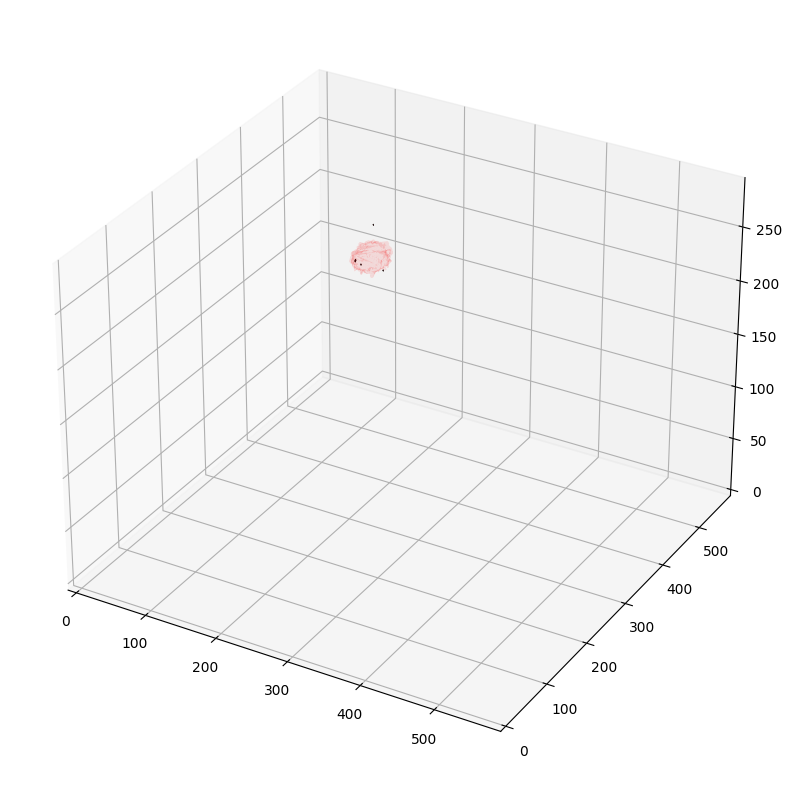

CPU times: user 4.9 s, sys: 2.43 s, total: 7.33 s
Wall time: 4.72 s


In [20]:
%%time
p = img2.transpose(2, 1, 0)
verts, faces, normals, values = measure.marching_cubes(p, 0)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

mesh = Poly3DCollection(verts[faces], alpha=0.05)
face_color = [1, 0, 0, 0.7]
mesh.set_facecolor(face_color)
ax.add_collection3d(mesh)

### bounding box
# axes = [x, y, z]
# data = np.zeros(axes)

# for i in range(np.min(xs), np.max(xs)):
#     for j in range(np.min(ys), np.max(ys)):
#         for k in range(np.min(zs), np.max(zs)):
#             data[i][j][k] = 1

# p = data.transpose(2, 1, 0)
# verts, faces, normals, values = measure.marching_cubes(p, 0)

# mesh = Poly3DCollection(verts[faces], alpha=0.20)
# face_color = [0.45, 0.45, 0.75]
# mesh.set_facecolor(face_color)
# ax.add_collection3d(mesh)

### kmeans center
axes = [x, y, z]
data = np.zeros(axes)

# for kmeans_clusters in kmeans_output:
#     data[int(kmeans_clusters[0])][int(kmeans_clusters[1])][int(kmeans_clusters[2])] = 1

for distrib in sorted_disto[0:1]:
    a = coordinates[distrib["index"]][0]
    b = coordinates[distrib["index"]][1]
    c = coordinates[distrib["index"]][2]
    data[a][b][c] = 1

p = data.transpose(2, 1, 0)

verts, faces, normals, values = measure.marching_cubes(p, 0)

mesh = Poly3DCollection(verts[faces], alpha=0.95)
face_color = [0, 0, 0]
mesh.set_facecolor(face_color)
ax.add_collection3d(mesh)

ax.set_xlim(0, p.shape[0])
ax.set_ylim(0, p.shape[1])
ax.set_zlim(0, p.shape[2])

# ax.view_init(90, 90)

plt.show()

In [ ]:
int('aa')

In [ ]:
%%time
xs = []
ys = []
zs = []
for a in range(len(coordinates)):
    xs.append(coordinates[a][0])
    ys.append(coordinates[a][1])
    zs.append(coordinates[a][2])

In [ ]:
print(np.min(xs))
print(np.min(ys))
print(np.min(zs))
print(np.max(xs))
print(np.max(ys)) 
print(np.max(zs)) 

In [ ]:
%%time
p = img2.transpose(2, 1, 0)
verts, faces, normals, values = measure.marching_cubes(p, 0)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

mesh = Poly3DCollection(verts[faces], alpha=0.70)
face_color = [1, 0, 0, 0.7]
mesh.set_facecolor(face_color)
ax.add_collection3d(mesh)

### bounding box
axes = [x, y, z]
data = np.zeros(axes)

for i in range(np.min(xs), np.max(xs)):
    for j in range(np.min(ys), np.max(ys)):
        for k in range(np.min(zs), np.max(zs)):
            data[i][j][k] = 1

p = data.transpose(2, 1, 0)
verts, faces, normals, values = measure.marching_cubes(p, 0)

mesh = Poly3DCollection(verts[faces], alpha=0.20)
face_color = [0.45, 0.45, 0.75]
mesh.set_facecolor(face_color)
ax.add_collection3d(mesh)

ax.set_xlim(0, p.shape[0])
ax.set_ylim(0, p.shape[1])
ax.set_zlim(0, p.shape[2])

# ax.view_init(90, 90)

plt.show()

### batch execution

In [ ]:
nodule_coordinates = []
dataset = 'HC'
for mask in tqdm(mask_list):
    
    img, origin, spacing = load_itk(mask)
    nodule_mask, spacing2 = resample(img, spacing)

    coord_nodule_mask = gen_coordinate_and_mask(nodule_mask)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    p = nodule_mask.transpose(2, 1, 0)
    verts, faces, normals, values = measure.marching_cubes(p, 0)
    mesh = Poly3DCollection(verts[faces], alpha=0.7)
    face_color = [1, 0, 0, 0.7] # red
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    p = coord_nodule_mask['nodule_mask'].transpose(2, 1, 0)
    verts, faces, normals, values = measure.marching_cubes(p, 0)
    mesh = Poly3DCollection(verts[faces], alpha=0.20)
    face_color = [0.45, 0.45, 0.75] # blue
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)
    
    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    raw_name = None
    if dataset == 'HC':
        raw_name = mask.split('/')[3]
    if dataset == 'MSD':
        raw_name = mask.split('/')[5].split('.')[0]
    plt.savefig(
        '/data/' + dataset + '-nodules-coordinates-preview/' + raw_name + '.png'
    )
    plt.close()
    matplotlib.use('Agg')

    nodule_coordinates.append({
        "x_min": coord_nodule_mask["x_min"],
        "y_min": coord_nodule_mask["y_min"],
        "z_min": coord_nodule_mask["z_min"],
        "x_max": coord_nodule_mask["x_max"],
        "y_max": coord_nodule_mask["y_max"],
        "z_max": coord_nodule_mask["z_max"]
    })

    plt.show()

nodule_coordinates

In [ ]:
np.unique(coord_nodule_mask['nodule_mask'], return_counts=True)

In [ ]:
nodule_coordinates = pd.DataFrame(nodule_coordinates)
nodule_coordinates.to_csv('/data/output/hc_nodules.csv')
nodule_coordinates.head()